In [1]:
# !pip install pandas
# !pip install sentence-transformers faiss-cpu
# !pip install --upgrade pip

# !pip install faiss-cpu
# !pip install certifi


In [5]:
import pandas as pd
import oracledb
from tabulate import tabulate
import random
import re
import webbrowser
import networkx as nx
import matplotlib.pyplot as plt

# #SCRE
# username = 'svcGOCUI'
# password = 'DELL2023support#'
# host = 'gocplorlvpr18.amer.dell.com'
# port = '1521'
# service_name = 'gooap_rw_oud_tls.prd.amer.dell.com'

#DAO GE4 SIT
dbname="DAO_GE4"
username = 'SIT_BROWSER'
password = 'browse_s1t'
host = 'udmnlorrrsi2a01.amer.dell.com'
port = '1521'
service_name = 'fdr4s.sit.amer.dell.com'
fileName="DBColumnRelation_"+dbname+".csv"
def Retrive_VectorData():
    
    dsn = oracledb.makedsn(host, port, service_name=service_name)
    try :
        connection = oracledb.connect(user=username, password=password, dsn=dsn)   
        print("Connected to Oracle Database")
         
        cursor = connection.cursor()

        query = '''SELECT
                        fk.owner || '.' || fk.table_name AS Table_Name,
                        fk.column_name AS Column_Name,
                        r.owner || '.' || r.table_name AS Referenced_Table_Name,
                        r.column_name AS Referenced_Column_Name
                    FROM
                        all_cons_columns fk
                        JOIN all_constraints c ON fk.owner = c.owner AND fk.constraint_name = c.constraint_name
                        JOIN all_cons_columns r ON c.r_owner = r.owner AND c.r_constraint_name = r.constraint_name
                    WHERE
                        c.constraint_type = 'R'
                        --AND fk.owner = 'UFD_BASE'
                    ORDER BY
                        fk.table_name, fk.column_name'''

        cursor.execute(query)

        rows = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        data = pd.DataFrame(rows,columns=column_names)
        print(fileName)
       
        data.to_csv(fileName,index=False)
        table = tabulate(rows, headers=column_names, tablefmt="pretty")
        # print(table)
        # data = pd.read_excel("DataFromDB.xlsx")
       
       
        # print(type(data))
        # print(data)
        return data
     
    except Exception as e:
       print(f"An error occurred: {e}")
    finally:
        if connection:
            connection.close()
            print("Connection closed")

Connected to Oracle Database
DBColumnRelation_DAO_GE4.csv
Connection closed
Column Names: Index(['TABLE_NAME', 'COLUMN_NAME', 'REFERENCED_TABLE_NAME',
       'REFERENCED_COLUMN_NAME'],
      dtype='object')


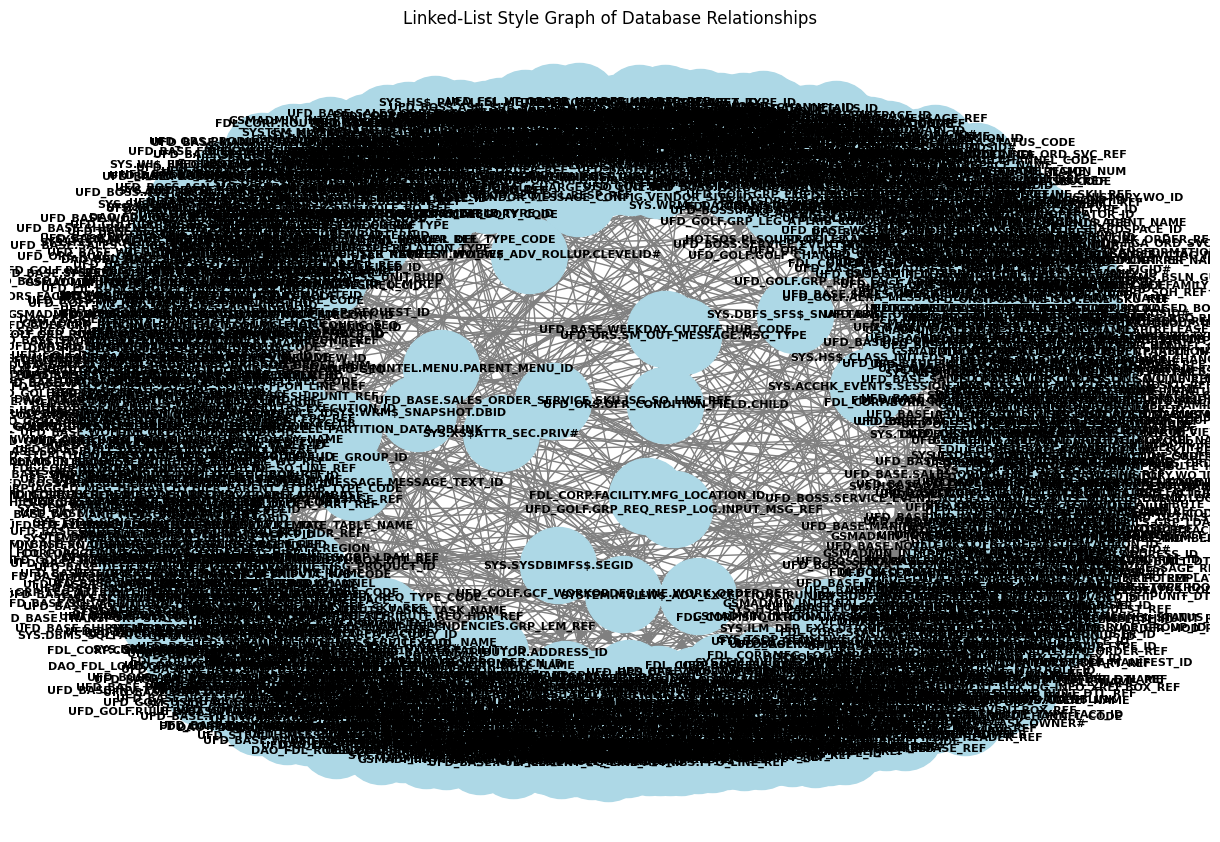

In [6]:
# After retrieving the data, inspect the column names
data = Retrive_VectorData()
# data = data[:500]

# Print the column names to debug
print("Column Names:", data.columns)

# Continue with the visualization if data is not empty
if not data.empty:
    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges to the graph based on the relationships
    for index, row in data.iterrows():
        # Use actual column names as observed
        G.add_edge(f"{row['TABLE_NAME']}.{row['COLUMN_NAME']}", 
                   f"{row['REFERENCED_TABLE_NAME']}.{row['REFERENCED_COLUMN_NAME']}")

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=20)  # Adjust layout
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray", arrowsize=20)
    plt.title("Linked-List Style Graph of Database Relationships")
    plt.show()
else:
    print("No data to visualize.")

808


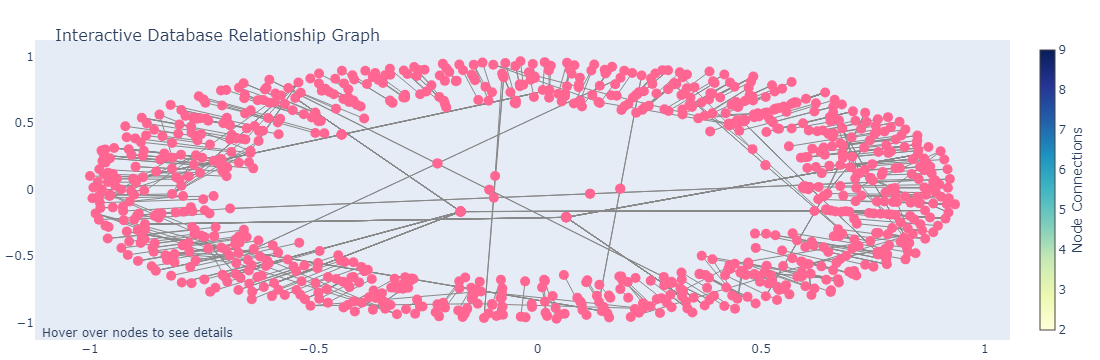

In [7]:
import pandas as pd
import networkx as nx
import plotly.graph_objs as go

def plot_interactive_graph(data):
    G = nx.DiGraph()

    # Add edges to the graph
    for index, row in data.iterrows():
        G.add_edge(f"{row['TABLE_NAME']}.{row['COLUMN_NAME']}", 
                   f"{row['REFERENCED_TABLE_NAME']}.{row['REFERENCED_COLUMN_NAME']}")

    pos = nx.spring_layout(G)

    # Create edge traces
    edge_trace = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace.append(go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=1, color='#888'),
            hoverinfo='none',
            mode='lines'))

    # Create node traces without labels initially
    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],  # Hover text
        mode='markers',
        hoverinfo='text',  # Show text only on hover
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        )
    )

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_info = node  # Node info to be displayed on hover
        node_trace['text'] += tuple([node_info])

    # Create the figure
    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        title='<br>Interactive Database Relationship Graph',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="Hover over nodes to see details",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )

    fig.show()

# # Call the function with your data
# data = Retrive_VectorData()
print(len(data))
if not data.empty:
    plot_interactive_graph(data)
